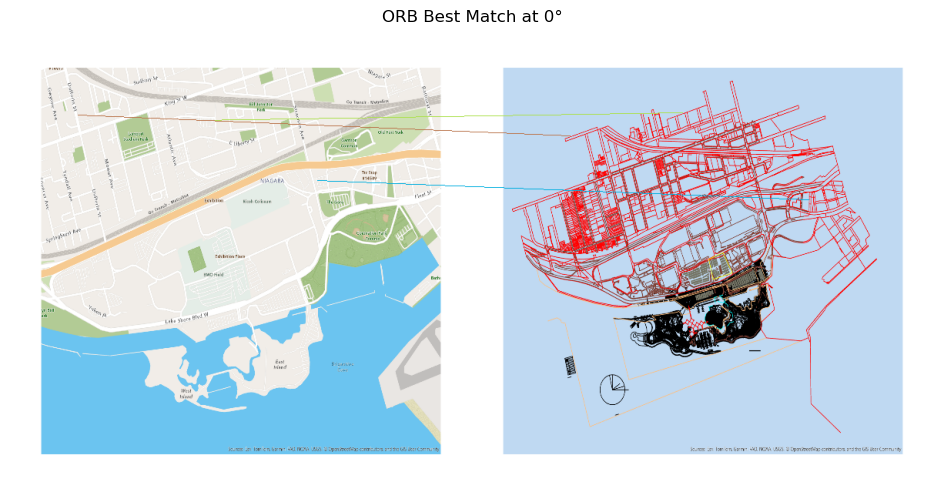

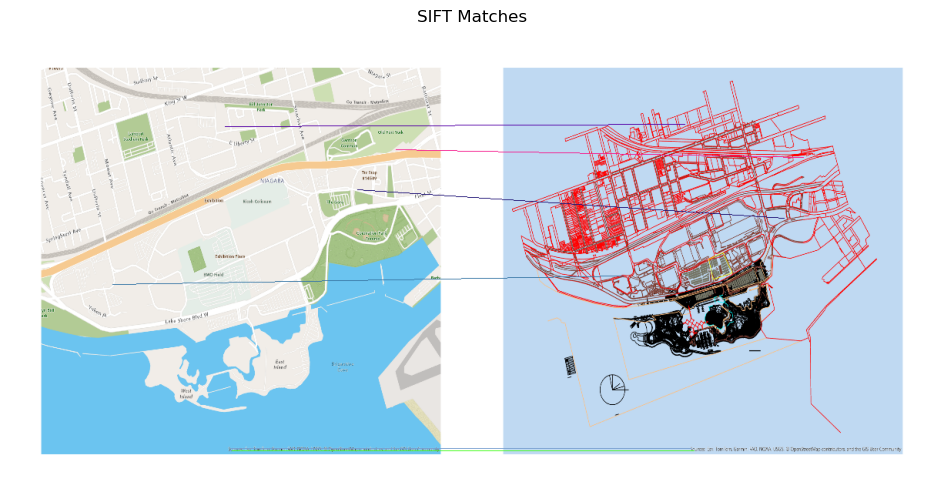

In [68]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import math

def preprocess_image(image, target_size=(600, 600)):
    """Reduce background noise while preserving main structures for both satellite and CAD images."""
    img_resized = cv2.resize(image, target_size)
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 15, 2)
    kernel = np.ones((3, 3), np.uint8)
    clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    return img_resized, gray, clean

def add_border(image, border_size=100):
    """Add a larger border around the image to exclude areas from matching."""
    return cv2.copyMakeBorder(image, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, value=(255, 255, 255))

def rotate_image(image, angle):
    """Rotate image by a given angle without cropping."""
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h))

def match_edge_maps(edges1, edges2, method="ORB"):
    """Match keypoints using ORB or SIFT."""
    if method == "ORB":
        detector = cv2.ORB_create(nfeatures=1000)
    else:
        detector = cv2.SIFT_create()
    
    kp1, des1 = detector.detectAndCompute(edges1, None)
    kp2, des2 = detector.detectAndCompute(edges2, None)
    
    if des1 is None or des2 is None:
        return None, [], []
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING if method == "ORB" else cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)[:100]
    
    return matches, kp1, kp2

def calculate_angle(p1, p2):
    """Calculate the angle of the line between two points relative to the x-axis (in degrees),
    ensuring the result is between 0 and 90 degrees."""
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    angle = abs(math.atan2(dy, dx) * 180.0 / math.pi)  # Convert to degrees and ensure positive
    angle = min(angle, 180 - angle)  # Ensure it's within 0-90 degrees
    return angle

def calculate_distance(p1, p2):
    """Calculate the Euclidean distance between two points."""
    return np.linalg.norm(np.array(p2) - np.array(p1))

def filter_extreme_slope_and_long_matches(matches, kp1, kp2, max_angle=45, max_distance_ratio=1.0):
    """Filter matches to remove those with extreme slopes or excessive distances."""
    filtered_matches = []
    max_distance = 0  # To track the longest distance
    
    # First pass: calculate the maximum distance
    for match in matches:
        p1 = tuple(map(int, kp1[match.queryIdx].pt))
        p2 = tuple(map(int, kp2[match.trainIdx].pt))
        distance = calculate_distance(p1, p2)
        max_distance = max(max_distance, distance)
    
    # Second pass: filter based on slope and distance
    for match in matches:
        p1 = tuple(map(int, kp1[match.queryIdx].pt))
        p2 = tuple(map(int, kp2[match.trainIdx].pt))
        
        # Calculate the angle of the line formed by the match (p1, p2)
        angle = calculate_angle(p1, p2)
        
        # Calculate the Euclidean distance between the points
        distance = calculate_distance(p1, p2)
        
        # Keep match only if:
        # 1. The angle is less than the max_angle threshold (not too steep)
        # 2. The distance is within a certain ratio of the max distance (not too long)
        if abs(angle) <= max_angle and distance <= max_distance * max_distance_ratio:
            filtered_matches.append(match)
    
    return filtered_matches

def filter_quadrant_matches(matches, kp1, kp2, img1_shape, img2_shape):
    """Filter matches to ensure that points are within the same quadrant in both images."""
    h1, w1 = img1_shape[:2]  # Ignore the channel dimension
    h2, w2 = img2_shape[:2]  # Ignore the channel dimension
    
    valid_matches = []
    for match in matches:
        p1 = kp1[match.queryIdx].pt
        p2 = kp2[match.trainIdx].pt
        
        # Determine quadrants for both images
        quadrant1 = (p1[0] < w1 // 2, p1[1] < h1 // 2)
        quadrant2 = (p2[0] < w2 // 2, p2[1] < h2 // 2)
        
        # Keep match only if they are in the same quadrant
        if quadrant1 == quadrant2:
            valid_matches.append(match)
    
    return valid_matches

def visualize_matches(img1, kp1, img2, kp2, matches, title):
    """Draw and visualize matched keypoints side by side."""
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR) if len(img1.shape) == 2 else img1
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR) if len(img2.shape) == 2 else img2
    
    new_h, new_w = max(h1, h2), w1 + w2
    canvas = np.zeros((new_h, new_w, 3), dtype=np.uint8)
    canvas[:h1, :w1] = img1
    canvas[:h2, w1:w1+w2] = img2
    
    for match in matches:
        kp1_pt = kp1[match.queryIdx].pt
        kp2_pt = (kp2[match.trainIdx].pt[0] + w1, kp2[match.trainIdx].pt[1])
        color = tuple(random.randint(0, 255) for _ in range(3))
        cv2.line(canvas, tuple(map(int, kp1_pt)), tuple(map(int, kp2_pt)), color, 1)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

satellite_path = "C:/Users/twool/Downloads/Drawing sample 2/OP_communitymap.tif"
cad_path = "C:/Users/twool/Downloads/Drawing sample 2/OP_ungeo.tif"
img1 = cv2.imread(satellite_path)
img2 = cv2.imread(cad_path)

# Add a larger border around the satellite image
border_size = 100
img1_with_border = add_border(img1, border_size)
img2_with_border = add_border(img2, border_size)

img1_processed, gray1, edges1 = preprocess_image(img1_with_border)
img2_processed, gray2, edges2 = preprocess_image(img2_with_border)

best_matches, best_kp1, best_kp2, best_angle = [], [], [], 0
for angle in range(0, 360, 10):
    edges2_rot = rotate_image(edges2, angle)
    matches, kp1, kp2 = match_edge_maps(edges1, edges2_rot, method="ORB")
    if matches and len(matches) > len(best_matches):
        best_matches, best_kp1, best_kp2, best_angle = matches, kp1, kp2, angle

# Filter matches to ensure they are in the same quadrant
best_matches = filter_quadrant_matches(best_matches, best_kp1, best_kp2, img1.shape, img2.shape)

# Filter for extreme slopes and long distances
best_matches = filter_extreme_slope_and_long_matches(best_matches, best_kp1, best_kp2, max_angle=45, max_distance_ratio=0.1)

visualize_matches(img1_processed, best_kp1, img2_processed, best_kp2, best_matches, f"ORB Best Match at {best_angle}°")

matches_sift, kp1_sift, kp2_sift = match_edge_maps(edges1, edges2, method="SIFT")
if matches_sift:
    #matches_sift = filter_quadrant_matches(matches_sift, kp1_sift, kp2_sift, img1.shape, img2.shape)
    matches_sift = filter_extreme_slope_and_long_matches(matches_sift, kp1_sift, kp2_sift, max_angle=45, max_distance_ratio=0.1)
    visualize_matches(img1_processed, kp1_sift, img2_processed, kp2_sift, matches_sift, "SIFT Matches")


11.996899307923579
3.6522227803063356
3.6214847041173397
49.57093663837347
0.9093804491991477
22.465755634149616
55.03585417506955
39.24759530618138
77.44975728267788
24.61254212767838
69.35300917502964
61.11341823308929
7.174324236482306
10.234802763423204
42.64347865421064
69.03428815944258
23.30826236674153
47.13324047861464
39.147298117908946
43.4198275272
56.98541411907973
63.35936076715291
43.11932176181335
52.54322629039889
77.0053832080835
65.69936705528158
67.52056560289687
80.2619248325185
17.94940299291386
26.726220314613073
43.08018987004451
20.334726563072337
18.895145990900716
3.9115718125286776
67.4258619213518
11.3099324740202
45.0
53.08213603676144
30.089686238776665
40.48601154199872
41.338064424480194
61.31385242626055
15.945395900922875
1.314754291382684
75.71890426402918
30.759233965468837
12.994616791916505
13.392497753751098
57.528807709151515
29.632568235366932
29.96674187061171
60.13308314848701
87.82868820908519
10.076880379222018
69.644416295365
8.66413543310

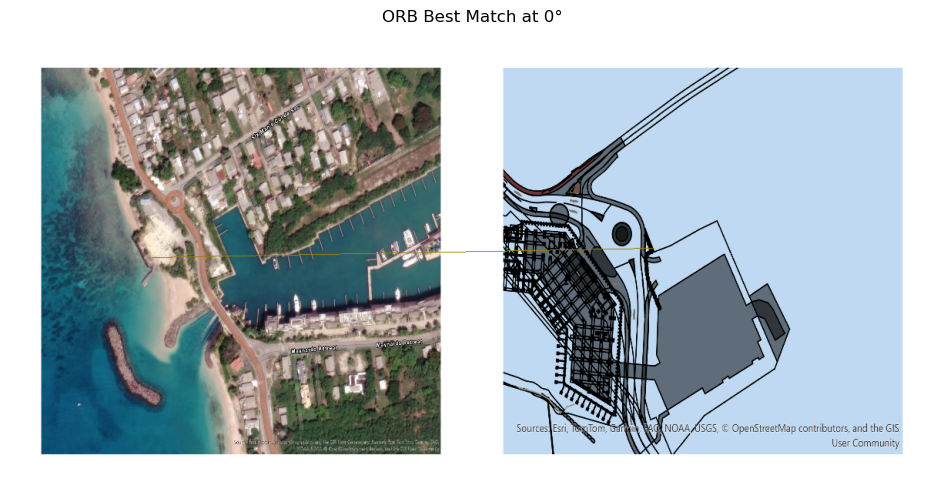

63.43494882292201
60.09406282503658
28.24973549497428
60.09406282503658
75.65066795705286
5.971565897796438
45.0
31.083122566698734
35.647020749906744
3.4099654231124195
18.11306580752327
45.0
2.4440680576354086
0.6820603931726623
10.561010691196373
72.74734783317875
79.11447294534128
18.881069347344027
3.5763343749973444
29.937332807623097
16.38101798105389
26.458355249175725
28.30075576600638
32.47119229084848
43.99098100604297
75.25643716352927
5.971565897796438
8.949458084208857
12.54432240671791
25.97439396243132
24.45953698822194
18.11306580752327
88.09876353538557
32.80183203074
2.4059705166453
13.985359130049362
14.036243467926482
88.80651057601797
70.06746343806049
23.638089267690656
23.638089267690656
73.96766064606402
55.88552705465874
3.6913859864512752
57.52880770915151
41.52368725079887
52.64728418021268
77.19573393471325
51.74314443074195
12.146573277683915
66.25050550713323
9.264523985132985
9.053438662173761
24.63318785955534
14.83367070569858
23.309360369867278
18.189

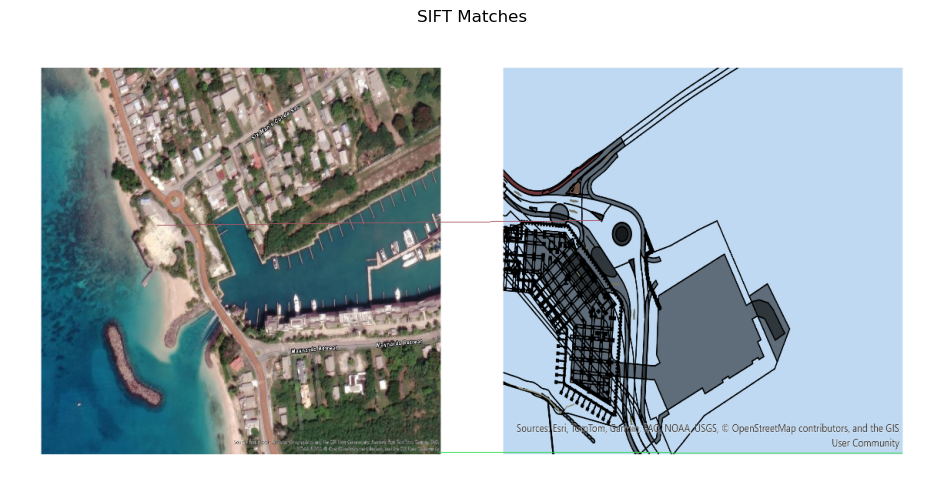

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import math

def preprocess_image(image, target_size=(600, 600)):
    """Reduce background noise while preserving main structures for both satellite and CAD images."""
    img_resized = cv2.resize(image, target_size)
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 15, 2)
    kernel = np.ones((3, 3), np.uint8)
    clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    return img_resized, gray, clean

def add_border(image, border_size=100):
    """Add a larger border around the image to exclude areas from matching."""
    return cv2.copyMakeBorder(image, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, value=(255, 255, 255))

def rotate_image(image, angle):
    """Rotate image by a given angle without cropping."""
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h))

def match_edge_maps(edges1, edges2, method="ORB"):
    """Match keypoints using ORB or SIFT."""
    if method == "ORB":
        detector = cv2.ORB_create(nfeatures=1000)
    else:
        detector = cv2.SIFT_create()
    
    kp1, des1 = detector.detectAndCompute(edges1, None)
    kp2, des2 = detector.detectAndCompute(edges2, None)
    
    if des1 is None or des2 is None:
        return None, [], []
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING if method == "ORB" else cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)[:100]
    
    return matches, kp1, kp2

def calculate_angle(p1, p2):
    """Calculate the angle of the line between two points relative to the x-axis (in degrees),
    ensuring the result is between 0 and 90 degrees."""
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    angle = abs(math.atan2(dy, dx) * 180.0 / math.pi)  # Convert to degrees and ensure positive
    angle = min(angle, 180 - angle)  # Ensure it's within 0-90 degrees
    print(angle)
    return angle

def calculate_distance(p1, p2):
    """Calculate the Euclidean distance between two points."""
    return np.linalg.norm(np.array(p2) - np.array(p1))

def filter_extreme_slope_and_long_matches(matches, kp1, kp2, max_angle=60, max_distance_ratio=1.0):
    """Filter matches to remove those with extreme slopes or excessive distances."""
    filtered_matches = []
    max_distance = 0  # To track the longest distance
    
    # First pass: calculate the maximum distance
    for match in matches:
        p1 = tuple(map(int, kp1[match.queryIdx].pt))
        p2 = tuple(map(int, kp2[match.trainIdx].pt))
        distance = calculate_distance(p1, p2)
        max_distance = max(max_distance, distance)
    
    # Second pass: filter based on slope and distance
    for match in matches:
        p1 = tuple(map(int, kp1[match.queryIdx].pt))
        p2 = tuple(map(int, kp2[match.trainIdx].pt))
        
        # Calculate the angle of the line formed by the match (p1, p2)
        angle = calculate_angle(p1, p2)
        
        # Calculate the Euclidean distance between the points
        distance = calculate_distance(p1, p2)
        
        # Keep match only if:
        # 1. The angle is less than the max_angle threshold (not too steep)
        # 2. The distance is within a certain ratio of the max distance (not too long)
        if abs(angle) <= max_angle and distance <= max_distance * max_distance_ratio:
            filtered_matches.append(match)
    
    return filtered_matches

def filter_quadrant_matches(matches, kp1, kp2, img1_shape, img2_shape):
    """Filter matches to ensure that points are within the same quadrant in both images."""
    h1, w1 = img1_shape[:2]  # Ignore the channel dimension
    h2, w2 = img2_shape[:2]  # Ignore the channel dimension
    
    valid_matches = []
    for match in matches:
        p1 = kp1[match.queryIdx].pt
        p2 = kp2[match.trainIdx].pt
        
        # Determine quadrants for both images
        quadrant1 = (p1[0] < w1 // 2, p1[1] < h1 // 2)
        quadrant2 = (p2[0] < w2 // 2, p2[1] < h2 // 2)
        
        # Keep match only if they are in the same quadrant
        if quadrant1 == quadrant2:
            valid_matches.append(match)
    
    return valid_matches

def visualize_matches(img1, kp1, img2, kp2, matches, title):
    """Draw and visualize matched keypoints side by side."""
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR) if len(img1.shape) == 2 else img1
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR) if len(img2.shape) == 2 else img2
    
    new_h, new_w = max(h1, h2), w1 + w2
    canvas = np.zeros((new_h, new_w, 3), dtype=np.uint8)
    canvas[:h1, :w1] = img1
    canvas[:h2, w1:w1+w2] = img2
    
    for match in matches:
        kp1_pt = kp1[match.queryIdx].pt
        kp2_pt = (kp2[match.trainIdx].pt[0] + w1, kp2[match.trainIdx].pt[1])
        color = tuple(random.randint(0, 255) for _ in range(3))
        cv2.line(canvas, tuple(map(int, kp1_pt)), tuple(map(int, kp2_pt)), color, 1)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

satellite_path = "C:/Users/twool/Downloads/Drawing sample 1/Pendry_imagery_hybrid.tif"
cad_path = "C:/Users/twool/Downloads/Drawing sample 1/Pendry_ungeoreferenced.tif"
img1 = cv2.imread(satellite_path)
img2 = cv2.imread(cad_path)

# Add a larger border around the satellite image
border_size = 100
img1_with_border = add_border(img1, border_size)
img2_with_border = add_border(img2, border_size)

img1_processed, gray1, edges1 = preprocess_image(img1_with_border)
img2_processed, gray2, edges2 = preprocess_image(img2_with_border)

best_matches, best_kp1, best_kp2, best_angle = [], [], [], 0
for angle in range(0, 360, 10):
    edges2_rot = rotate_image(edges2, angle)
    matches, kp1, kp2 = match_edge_maps(edges1, edges2_rot, method="ORB")
    if matches and len(matches) > len(best_matches):
        best_matches, best_kp1, best_kp2, best_angle = matches, kp1, kp2, angle

# Filter matches to ensure they are in the same quadrant
best_matches = filter_quadrant_matches(best_matches, best_kp1, best_kp2, img1.shape, img2.shape)

# Filter for extreme slopes and long distances
best_matches = filter_extreme_slope_and_long_matches(best_matches, best_kp1, best_kp2, max_angle=45, max_distance_ratio=0.1)

visualize_matches(img1_processed, best_kp1, img2_processed, best_kp2, best_matches, f"ORB Best Match at {best_angle}°")

matches_sift, kp1_sift, kp2_sift = match_edge_maps(edges1, edges2, method="SIFT")
if matches_sift:
    #matches_sift = filter_quadrant_matches(matches_sift, kp1_sift, kp2_sift, img1.shape, img2.shape)
    matches_sift = filter_extreme_slope_and_long_matches(matches_sift, kp1_sift, kp2_sift, max_angle=45, max_distance_ratio=0.1)
    visualize_matches(img1_processed, kp1_sift, img2_processed, kp2_sift, matches_sift, "SIFT Matches")


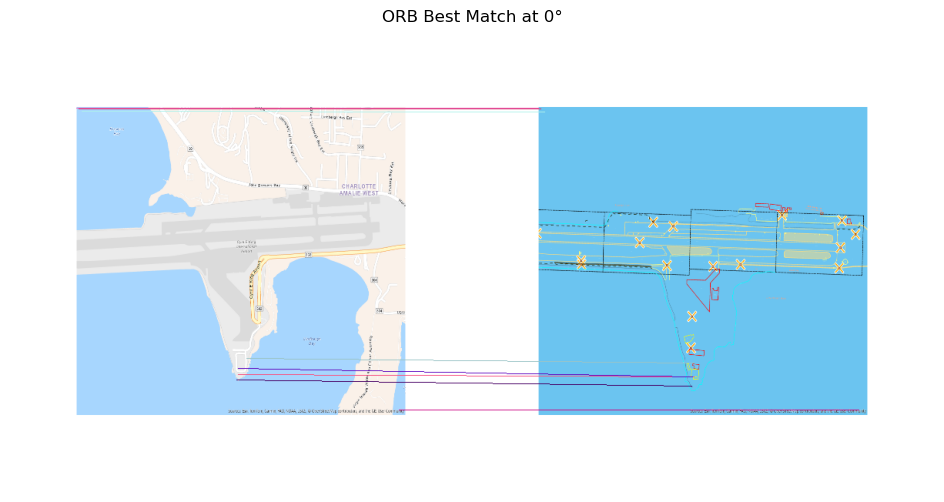

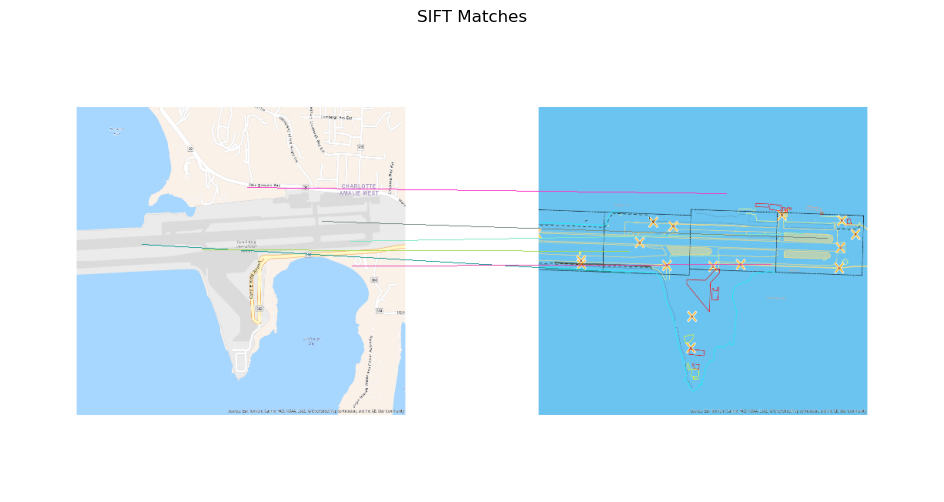

In [70]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import math

def preprocess_image(image, target_size=(600, 600)):
    """Reduce background noise while preserving main structures for both satellite and CAD images."""
    img_resized = cv2.resize(image, target_size)
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 15, 2)
    kernel = np.ones((3, 3), np.uint8)
    clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    return img_resized, gray, clean

def add_border(image, border_size=100):
    """Add a larger border around the image to exclude areas from matching."""
    return cv2.copyMakeBorder(image, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, value=(255, 255, 255))

def rotate_image(image, angle):
    """Rotate image by a given angle without cropping."""
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h))

def match_edge_maps(edges1, edges2, method="ORB"):
    """Match keypoints using ORB or SIFT."""
    if method == "ORB":
        detector = cv2.ORB_create(nfeatures=1000)
    else:
        detector = cv2.SIFT_create()
    
    kp1, des1 = detector.detectAndCompute(edges1, None)
    kp2, des2 = detector.detectAndCompute(edges2, None)
    
    if des1 is None or des2 is None:
        return None, [], []
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING if method == "ORB" else cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)[:100]
    
    return matches, kp1, kp2

def calculate_angle(p1, p2):
    """Calculate the angle of the line between two points relative to the x-axis (in degrees),
    ensuring the result is between 0 and 90 degrees."""
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    angle = abs(math.atan2(dy, dx) * 180.0 / math.pi)  # Convert to degrees and ensure positive
    angle = min(angle, 180 - angle)  # Ensure it's within 0-90 degrees
    return angle

def calculate_distance(p1, p2):
    """Calculate the Euclidean distance between two points."""
    return np.linalg.norm(np.array(p2) - np.array(p1))

def filter_extreme_slope_and_long_matches(matches, kp1, kp2, max_angle=90, max_distance_ratio=0.5):
    """Filter matches to remove those with extreme slopes or excessive distances."""
    filtered_matches = []
    max_distance = 0  # To track the longest distance
    
    # First pass: calculate the maximum distance
    for match in matches:
        p1 = tuple(map(int, kp1[match.queryIdx].pt))
        p2 = tuple(map(int, kp2[match.trainIdx].pt))
        distance = calculate_distance(p1, p2)
        max_distance = max(max_distance, distance)
    
    # Second pass: filter based on slope and distance
    for match in matches:
        p1 = tuple(map(int, kp1[match.queryIdx].pt))
        p2 = tuple(map(int, kp2[match.trainIdx].pt))
        
        # Calculate the angle of the line formed by the match (p1, p2)
        angle = calculate_angle(p1, p2)
        
        # Calculate the Euclidean distance between the points
        distance = calculate_distance(p1, p2)
        
        # Keep match only if:
        # 1. The angle is less than the max_angle threshold (not too steep)
        # 2. The distance is within a certain ratio of the max distance (not too long)
        if abs(angle) <= max_angle and distance <= max_distance * max_distance_ratio:
            filtered_matches.append(match)
    
    return filtered_matches

def filter_quadrant_matches(matches, kp1, kp2, img1_shape, img2_shape):
    """Filter matches to ensure that points are within the same quadrant in both images."""
    h1, w1 = img1_shape[:2]  # Ignore the channel dimension
    h2, w2 = img2_shape[:2]  # Ignore the channel dimension
    
    valid_matches = []
    for match in matches:
        p1 = kp1[match.queryIdx].pt
        p2 = kp2[match.trainIdx].pt
        
        # Determine quadrants for both images
        quadrant1 = (p1[0] < w1 // 2, p1[1] < h1 // 2)
        quadrant2 = (p2[0] < w2 // 2, p2[1] < h2 // 2)
        
        # Keep match only if they are in the same quadrant
        if quadrant1 == quadrant2:
            valid_matches.append(match)
    
    return valid_matches

def visualize_matches(img1, kp1, img2, kp2, matches, title):
    """Draw and visualize matched keypoints side by side."""
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR) if len(img1.shape) == 2 else img1
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR) if len(img2.shape) == 2 else img2
    
    new_h, new_w = max(h1, h2), w1 + w2
    canvas = np.zeros((new_h, new_w, 3), dtype=np.uint8)
    canvas[:h1, :w1] = img1
    canvas[:h2, w1:w1+w2] = img2
    
    for match in matches:
        kp1_pt = kp1[match.queryIdx].pt
        kp2_pt = (kp2[match.trainIdx].pt[0] + w1, kp2[match.trainIdx].pt[1])
        color = tuple(random.randint(0, 255) for _ in range(3))
        cv2.line(canvas, tuple(map(int, kp1_pt)), tuple(map(int, kp2_pt)), color, 1)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

satellite_path = "C:/Users/twool/Downloads/Drawing sample 3/US_Virgin_Airpotrt_Communit.tif"
cad_path = "C:/Users/twool/Downloads/Drawing sample 3/US_Virgin_Airpotrt_CAD_ungeoreferenced.tif"
img1 = cv2.imread(satellite_path)
img2 = cv2.imread(cad_path)

# Add a larger border around the satellite image
border_size = 200
img1_with_border = add_border(img1, border_size)
img2_with_border = add_border(img2, border_size)

img1_processed, gray1, edges1 = preprocess_image(img1_with_border)
img2_processed, gray2, edges2 = preprocess_image(img2_with_border)

best_matches, best_kp1, best_kp2, best_angle = [], [], [], 0
for angle in range(0, 360, 10):
    edges2_rot = rotate_image(edges2, angle)
    matches, kp1, kp2 = match_edge_maps(edges1, edges2_rot, method="ORB")
    if matches and len(matches) > len(best_matches):
        best_matches, best_kp1, best_kp2, best_angle = matches, kp1, kp2, angle

# Filter matches to ensure they are in the same quadrant
best_matches = filter_quadrant_matches(best_matches, best_kp1, best_kp2, img1.shape, img2.shape)

# Filter for extreme slopes and long distances
best_matches = filter_extreme_slope_and_long_matches(best_matches, best_kp1, best_kp2, max_angle=55, max_distance_ratio=0.1)

visualize_matches(img1_processed, best_kp1, img2_processed, best_kp2, best_matches, f"ORB Best Match at {best_angle}°")

matches_sift, kp1_sift, kp2_sift = match_edge_maps(edges1, edges2, method="SIFT")
if matches_sift:
    #matches_sift = filter_quadrant_matches(matches_sift, kp1_sift, kp2_sift, img1.shape, img2.shape)
    matches_sift = filter_extreme_slope_and_long_matches(matches_sift, kp1_sift, kp2_sift, max_angle=60, max_distance_ratio=0.12)
    visualize_matches(img1_processed, kp1_sift, img2_processed, kp2_sift, matches_sift, "SIFT Matches")
